In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2_contingency

from myfunctions import plot_categorical_features

import warnings
warnings.filterwarnings("ignore")

First, we load the dataframe with the categorical variables from notebook 1.

In [10]:
df = pd.read_pickle('./data/df.pkl')
df.head(3)

,age,gender,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score,CID
0,18,F,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0,xxxxxxxx
1,32,F,City,Premium Membership,2017-08-28,Unknown,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,0,CID
2,44,F,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1,CID


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   age                           36992 non-null  int64         
 1   gender                        36992 non-null  category      
 2   region_category               31564 non-null  category      
 3   membership_category           36992 non-null  object        
 4   joining_date                  36992 non-null  datetime64[ns]
 5   joined_through_referral       36992 non-null  category      
 6   referral_id                   36992 non-null  object        
 7   preferred_offer_types         36704 non-null  category      
 8   medium_of_operation           36992 non-null  category      
 9   internet_option               36992 non-null  category      
 10  last_visit_time               36992 non-null  object        
 11  days_since_last_login       

To get a rough overview, we plot all data.

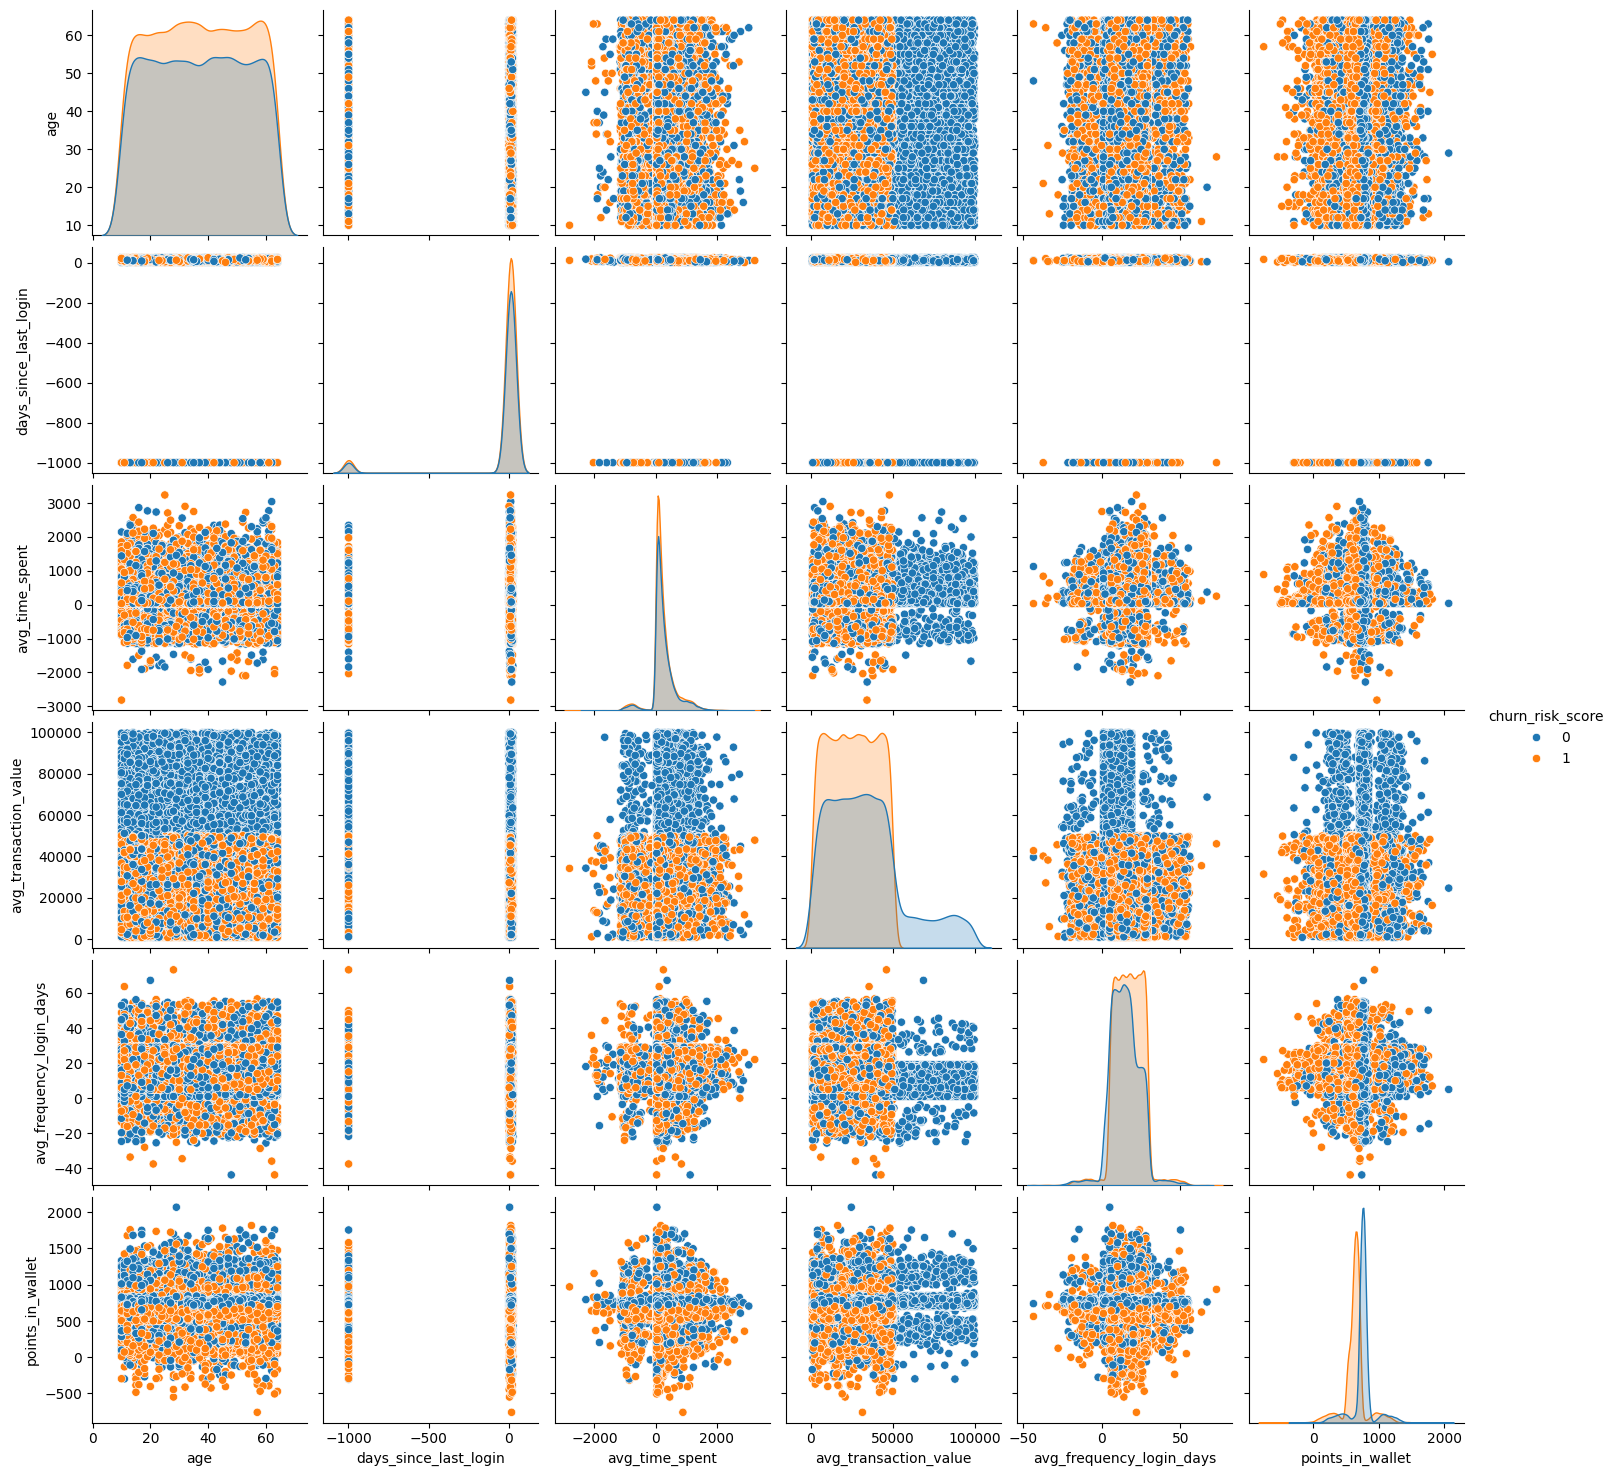

In [12]:
sns.pairplot(df, hue='churn_risk_score')

Caution when comparing absolute values: there are more churn_risk 1 than churn_risk 0 cases.
- age: no obvious trend
- days_since_last_login: has lots of values at '-999' which doesn't make sense in terms of days. We assume that '-999' means that a customer hasn't logged in at all and thus that there should be no interaction at all. Let's check that later.
- avg_time_spent: no obvious trend
- avg_transaction_value: If avg_transaction_value > 50 000, there are only churn 0
- avg_frequency_login_days: no obvious trend
- points_in_wallet: churn 0 tend to have more points in wallet

Let's have a look the plot for subdataframe where 'days_since_last_login' is '-999'

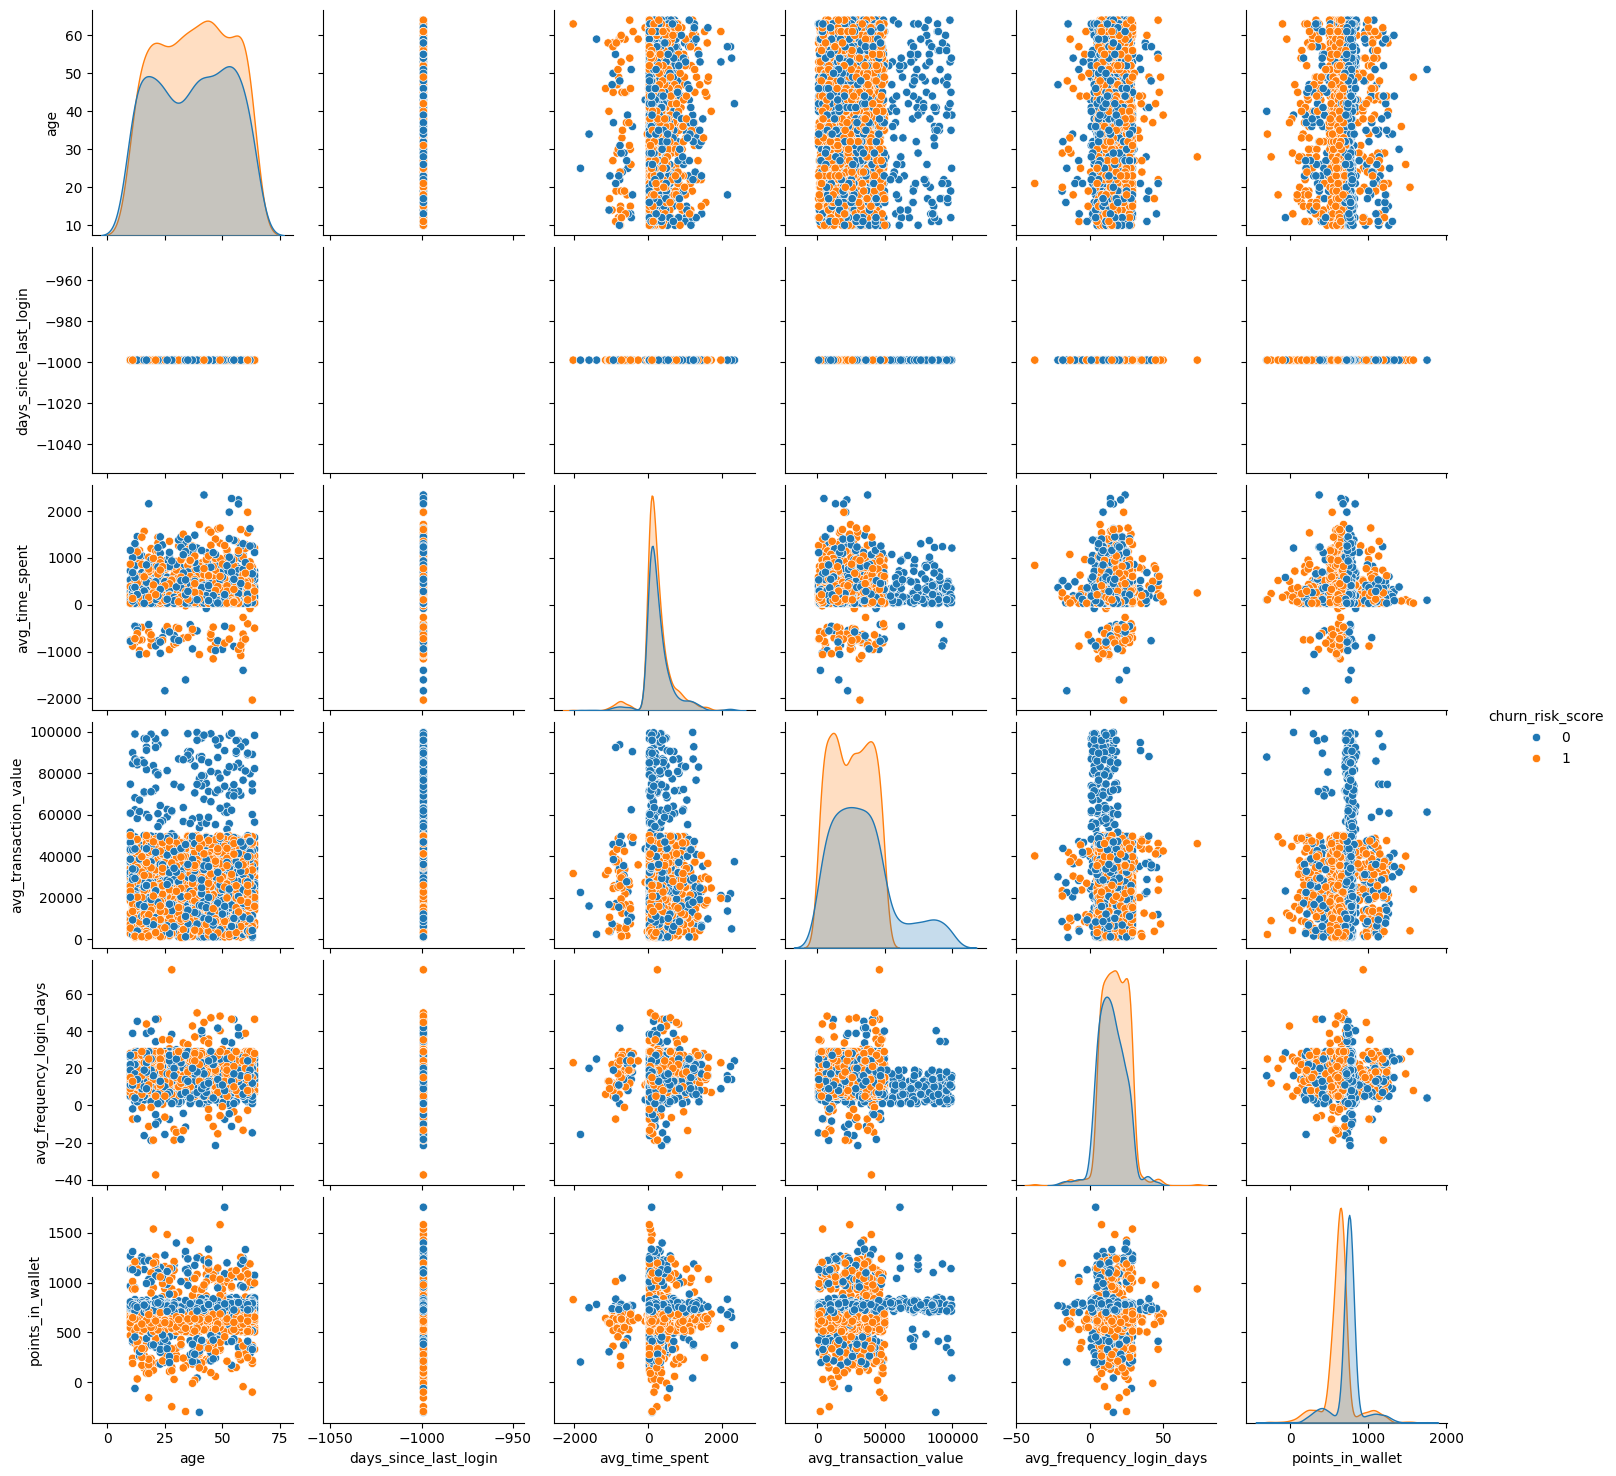

In [13]:
sns.pairplot(df[df['days_since_last_login'] == -999], hue='churn_risk_score')

We can see that values of '-999' for 'days_since_last_login' does not mean that the customers haven't interacted with the site as previously assumed.Looking at the distributions, there is no differece to the whole df.

Next, we want to examine the categorical variables further. For this we need a list of all catecorical variables to filter the df. To filter the df, we make a new df_categorical by dropping numerical variables, 'referral_id' and 'churn_risk_score'.

In [16]:
numerical = ['points_in_wallet', 'avg_frequency_login_days', 'avg_transaction_value', 'avg_time_spent', 'days_since_last_login', 'age', 'joining_date', 'last_visit_time']
df_categorical = df.drop(numerical, axis = 1)
df_categorical = df_categorical.drop('referral_id', axis = 1)
df_categorical = df_categorical.drop('churn_risk_score', axis = 1)

In [15]:
df_categorical.head()

,gender,region_category,membership_category,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,CID
0,F,Village,Platinum Membership,No,Gift Vouchers/Coupons,?,Wi-Fi,Yes,Yes,No,Not Applicable,Products always in Stock,xxxxxxxx
1,F,City,Premium Membership,Unknown,Gift Vouchers/Coupons,Desktop,Mobile_Data,Yes,No,Yes,Solved,Quality Customer Care,CID
2,F,Town,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,No,Yes,Yes,Solved in Follow-up,Poor Website,CID
3,M,City,No Membership,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,No,Yes,Yes,Unsolved,Poor Website,CID
4,F,City,No Membership,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,No,Yes,Yes,Solved,Poor Website,xxxxxxxx


We want to plot the absolute numbers compared to the relative numbers for each categorical variable. To achieve this, we use the newly created df_categorical to filter the df.
We do this to get an overview of how important each variable is. We have a look ar the relative value to better examine underrepresented values.

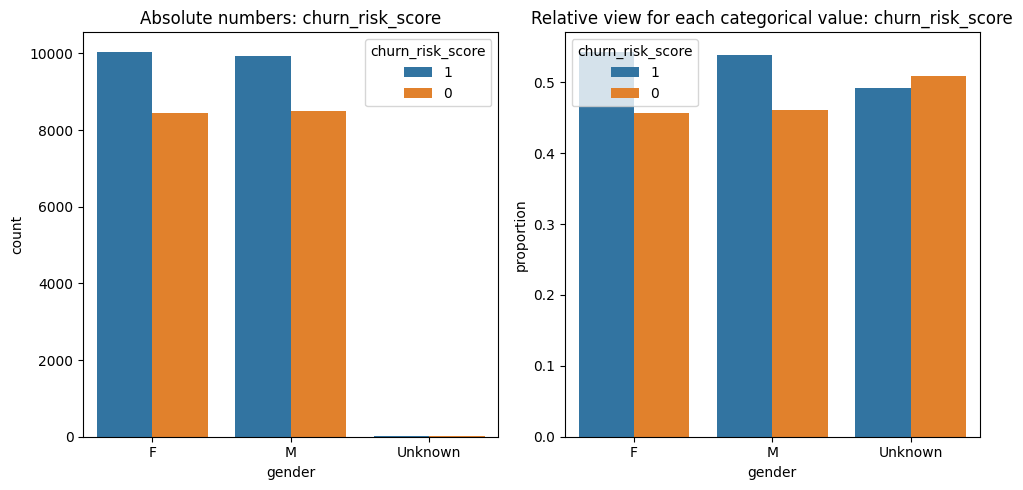

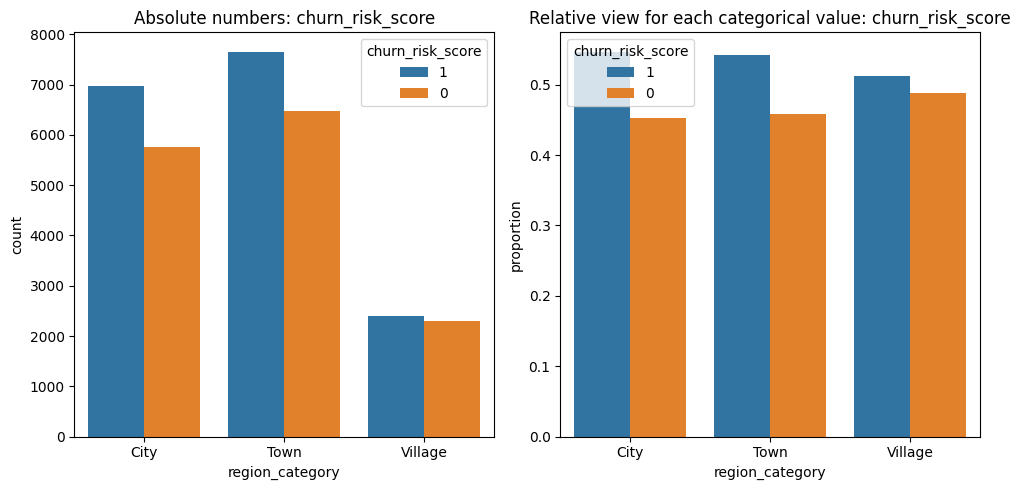

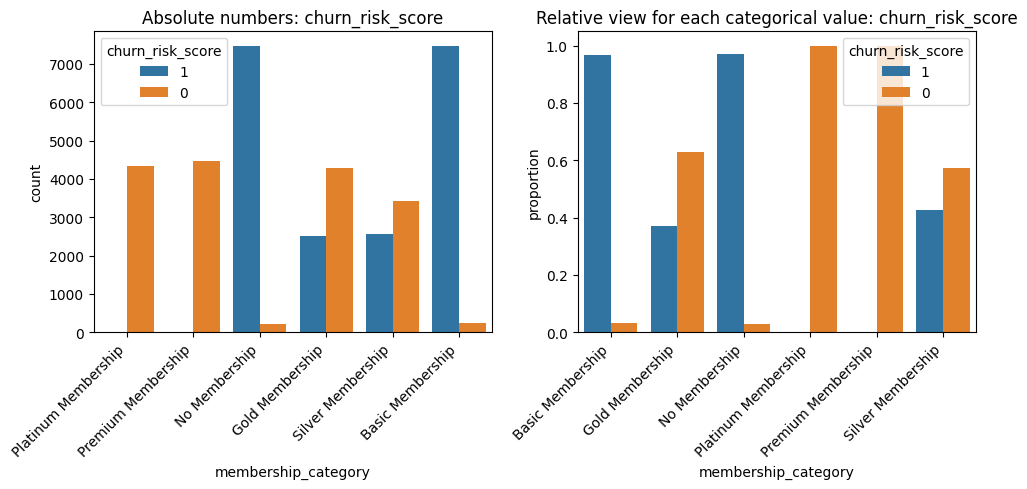

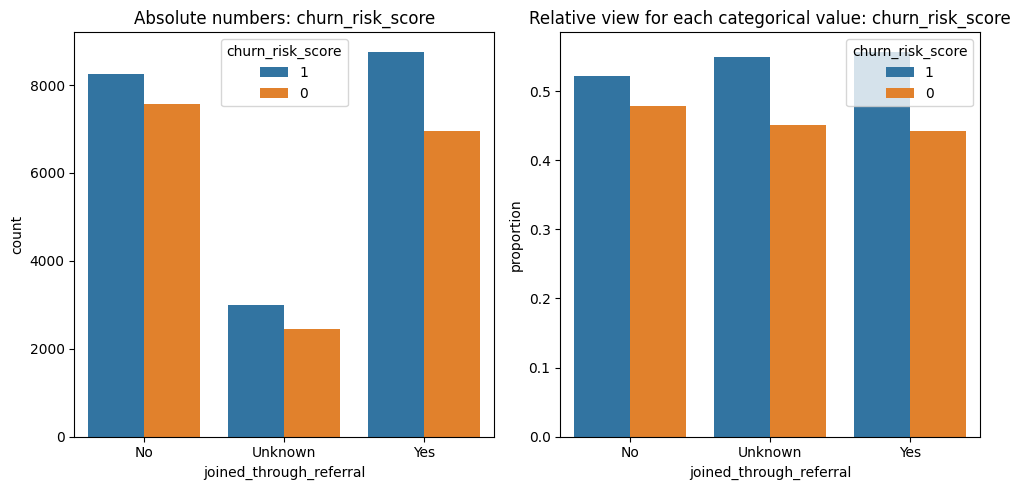

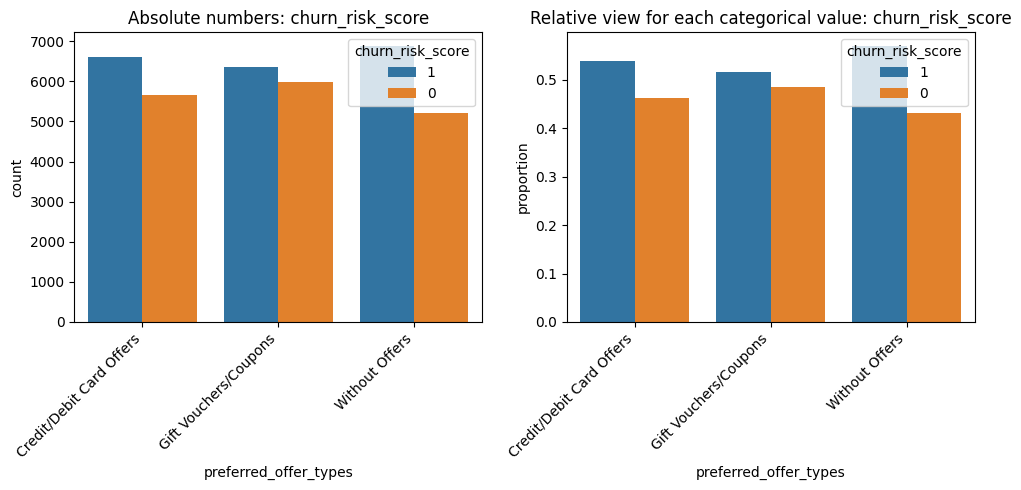

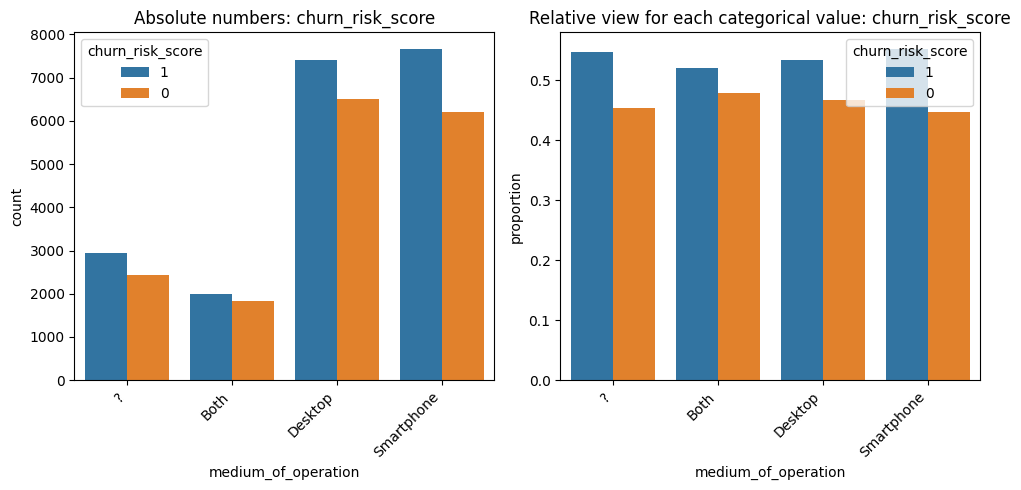

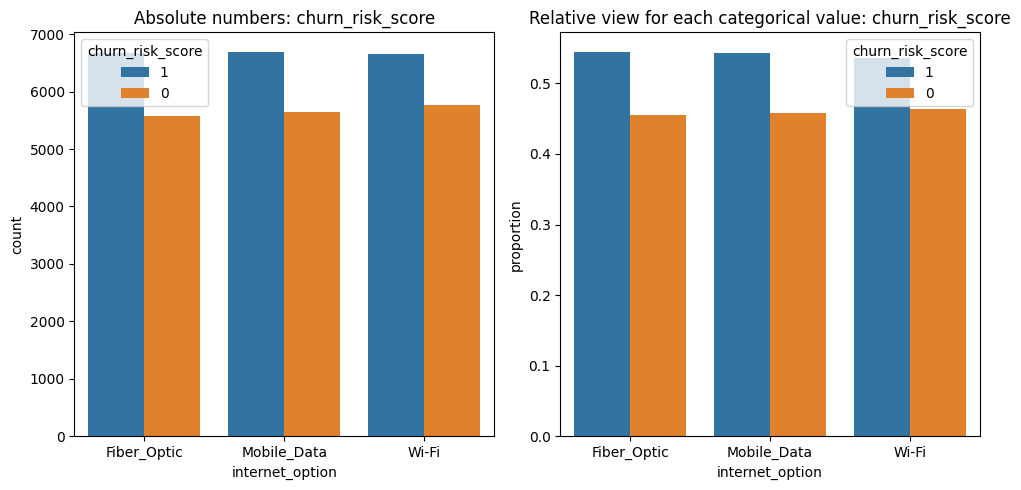

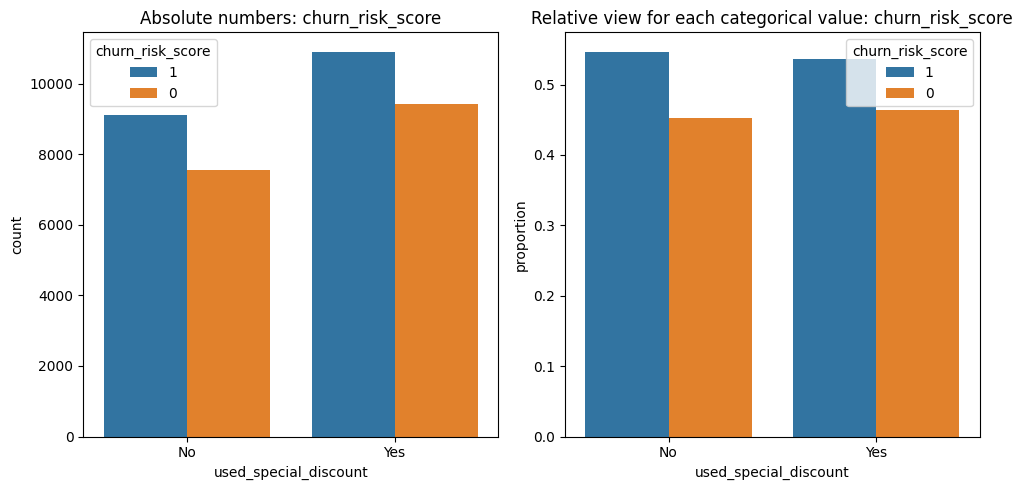

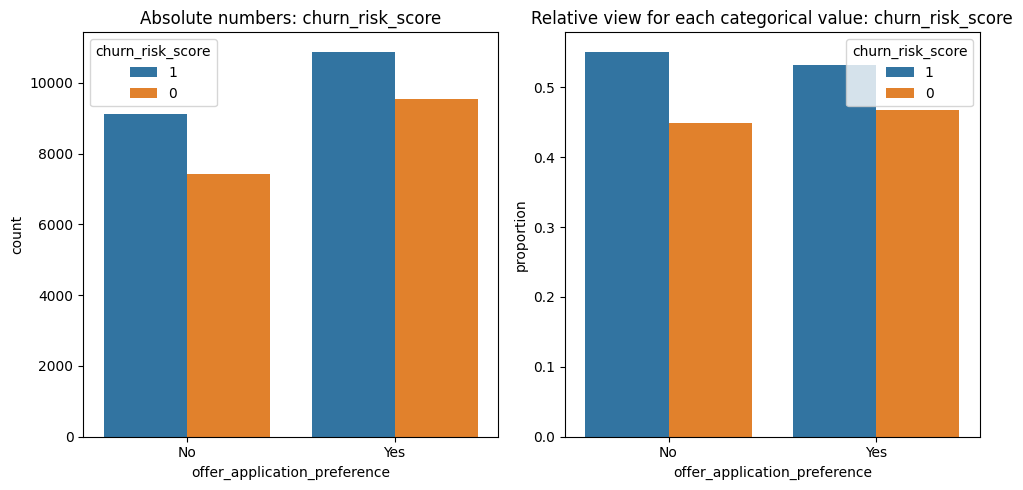

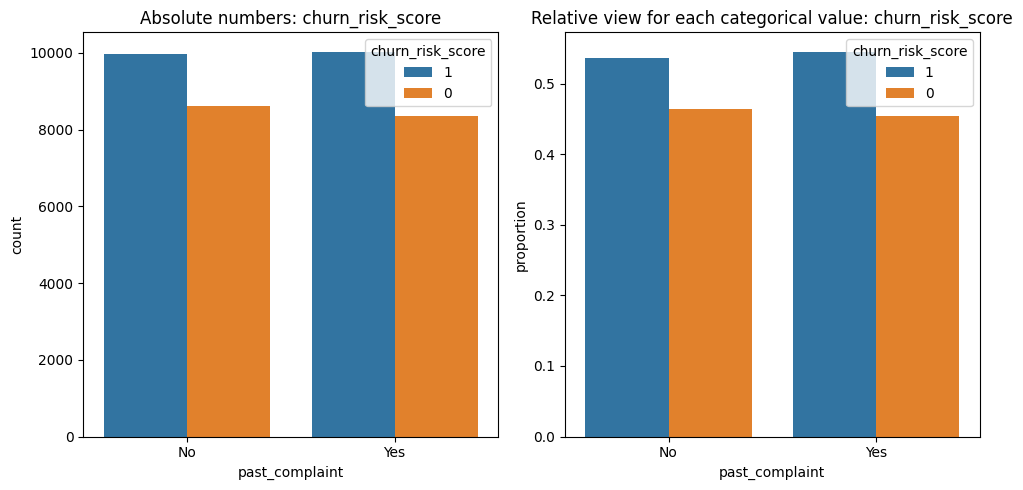

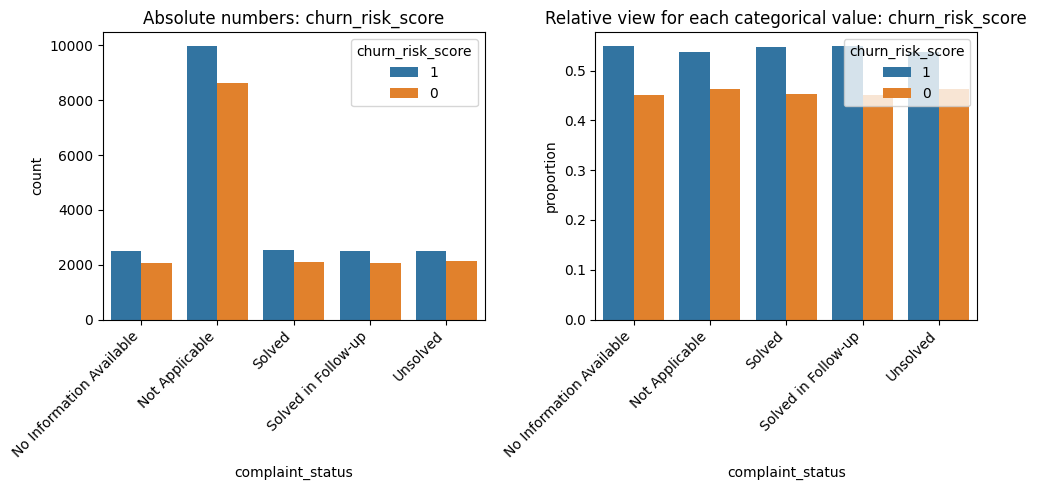

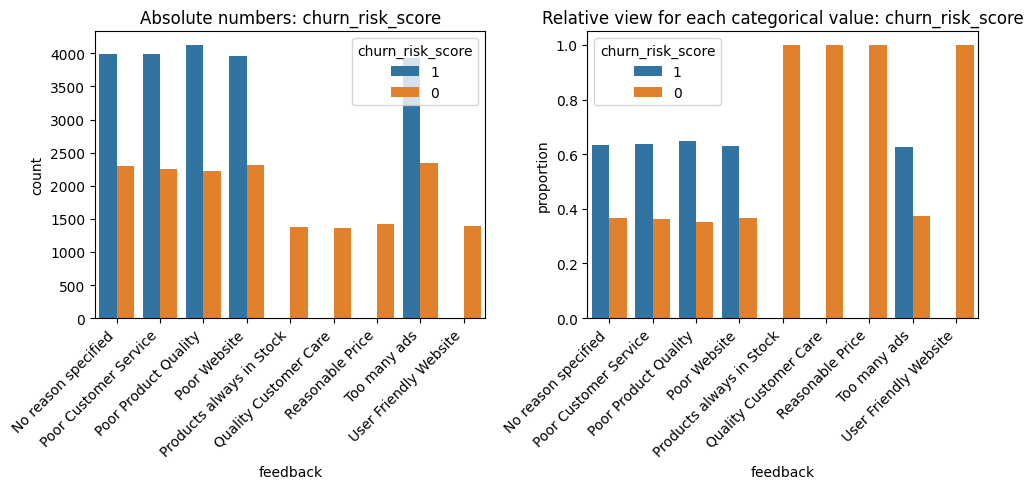

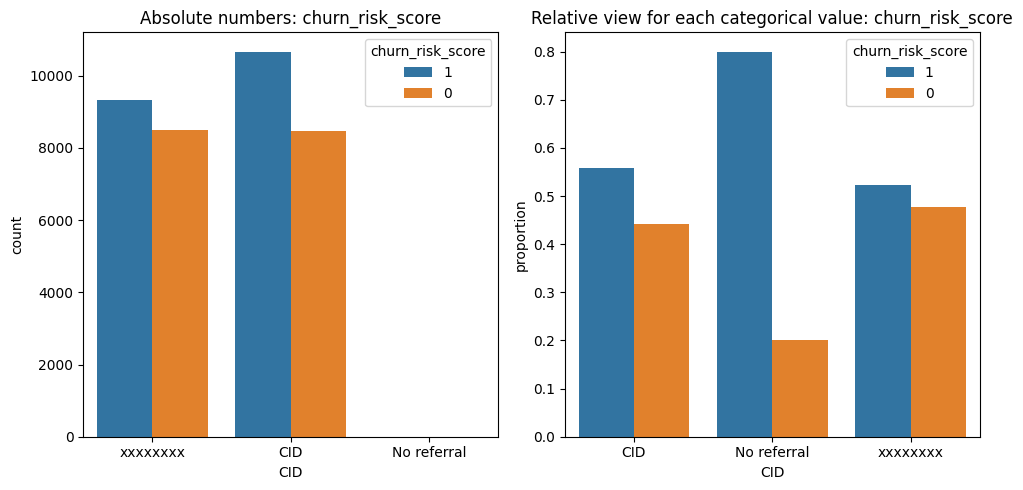

In [18]:
# Drop numerical features, predictions and ground truth ("churn_risk_score") to focus on categorical ones
#categorical_features = [col for col in df.columns if col not in numerical and col not in "churn_risk_score"]
categorical_features = df_categorical.columns
# Plot a absolute an relative barplot of the classification outcome for each categorical feature
plot_categorical_features(df=df, features=categorical_features, hue='churn_risk_score')

## First Learning from Categorical values

Major impact
- **Feedback**: Only customers giving negative feedback tend to churn. Customers giving positive feedback always stay.
- **membership_category**: higher levels less likely to churn

Minor impact 
- **region_category**
- preferred_offer_types
- used_special_discount
- offer_application_reference
- **past_complaint**: Interesting considering the importance of **feedback**
- **CID**: Seems to have some minor importance


No impact
- gender
- joined_through_referral
- medium_of_operation
- internet_option
- **complaint_status**: Interesting considering the importance of **feedback**; prevention probably more important than solving a problem

## Correlation

To get a correlation heatmap we use Cramer's V.This is the standard to use when comparing nominal scaled data.

In [9]:
# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate Cramer's V for all pairs of categorical variables
corr_matrix = pd.DataFrame(index=df_categorical.columns, columns=df_categorical.columns)
for i in range(len(df_categorical.columns)):
    for j in range(len(df_categorical.columns)):
        if i != j:
            corr_matrix.iloc[i, j] = cramers_v(df[df_categorical.columns[i]], df[df_categorical.columns[j]])

# Fill diagonal with 1 (maximum correlation)
np.fill_diagonal(corr_matrix.values, 1.0)

print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
                                gender region_category membership_category  \
gender                             1.0             0.0                 0.0   
region_category                    0.0             1.0            0.015581   
membership_category                0.0        0.015581                 1.0   
joined_through_referral            0.0             0.0            0.022075   
preferred_offer_types         0.005141        0.005616             0.02468   
medium_of_operation           0.002164             0.0            0.012916   
internet_option                    0.0        0.001856            0.002752   
used_special_discount              0.0             0.0             0.00375   
offer_application_preference       0.0             0.0            0.011086   
past_complaint                0.004095        0.004112              0.0045   
complaint_status                   0.0         0.00484                 0.0   
feedback                      0.002681      

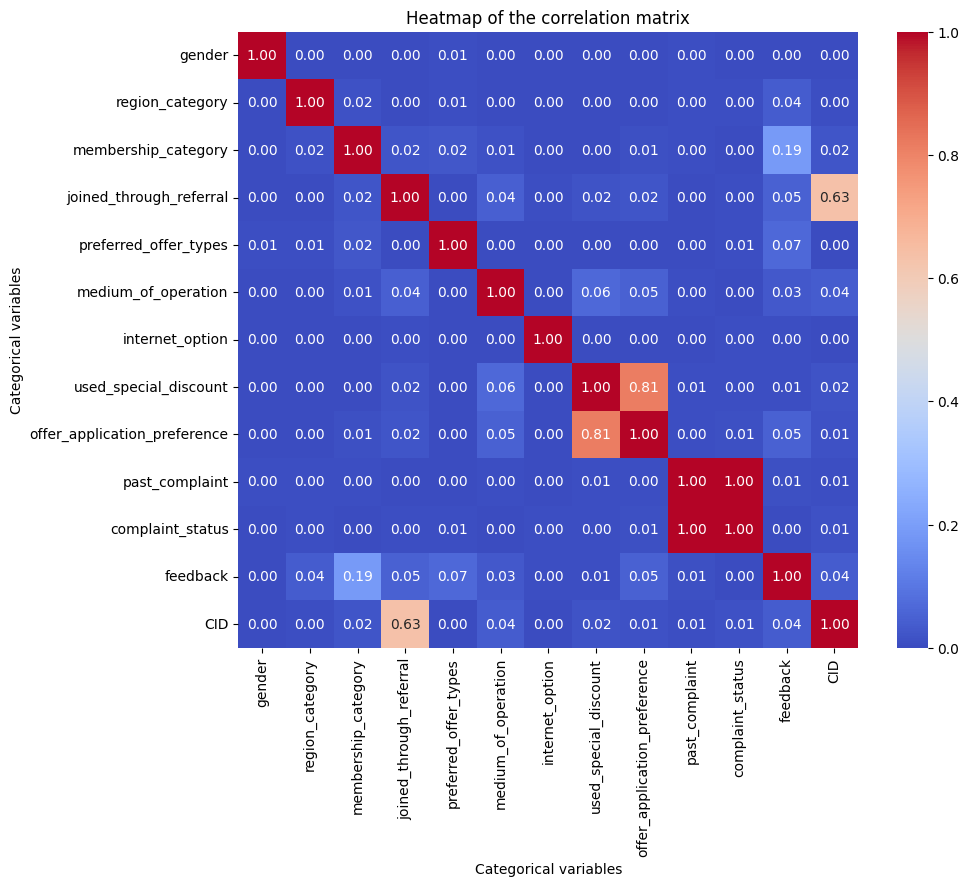

In [10]:
# Convert all values of the matrix to numerical values
corr_matrix = corr_matrix.apply(pd.to_numeric, errors='coerce')

# Create a heatmap from the correlation matrix
plt.figure(figsize=(10, 8))  # Plot size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Title and labels
plt.title('Heatmap of the correlation matrix')
plt.xlabel('Categorical variables')
plt.ylabel('Categorical variables')

# Show plot
plt.show()

# Observations from the heatmap 

## 1. 'past_complaint' and 'complaint_status' correlate with 1.0 

-> We will drop 'past_complaint' because it contains less information than 'complaint_status' to avoid multi-colinearity for some models.

## 2. 'used_special_discount' and 'offer_application_preference' correlate with 0.81

In [11]:
# A crosstab between: 'used_special_discount' and 'offer_application_preference'

comparing_matrix = pd.crosstab(df['used_special_discount'], df['offer_application_preference'])
print(comparing_matrix)
print('-----')
# examine how much information both features have for prediction
comparing_used = pd.crosstab(df['used_special_discount'], df['churn_risk_score'])
print(comparing_used)
print('-----')
comparing_offer = pd.crosstab(df['offer_application_preference'], df['churn_risk_score'])
print(comparing_offer)

offer_application_preference     No    Yes
used_special_discount                     
No                                0  16650
Yes                           16552   3790
-----
churn_risk_score          0      1
used_special_discount             
No                     7545   9105
Yes                    9435  10907
-----
churn_risk_score                 0      1
offer_application_preference             
No                            7426   9126
Yes                           9554  10886


-> We will drop 'offer_application_discount' because 'used_special_discount' depicts active behaviour of the customer to avoid multi-colinearity for some models.

## 3. 'CID' and 'joined_through_referral' correlate at 0.63

In [12]:
# A crosstab between: 'CID' and 'joined_through_referral'

comparing_referral= pd.crosstab(df['CID'], df['joined_through_referral'])
print(comparing_referral)
print('-----')
# examine how much information both features have for prediction
comparing_CID= pd.crosstab(df['CID'], df['churn_risk_score'])
print(comparing_CID)
print('-----')
comparing_joined= pd.crosstab(df['joined_through_referral'], df['churn_risk_score'])
print(comparing_joined)

joined_through_referral     No  Unknown    Yes
CID                                           
CID                          0     4876  14265
No referral                  0        1      4
xxxxxxxx                 15839      561   1446
-----
churn_risk_score     0      1
CID                          
CID               8472  10669
No referral          1      4
xxxxxxxx          8507   9339
-----
churn_risk_score            0     1
joined_through_referral            
No                       7576  8263
Unknown                  2452  2986
Yes                      6952  8763


       referral_id  churn_risk_score
1            21329                 0
2            12313                 1
3             3793                 1
6            24708                 0
7            56614                 1
...            ...               ...
36980        50925                 0
36981        50041                 0
36983        45477                 1
36986        15800                 0
36989         3838                 1

[19141 rows x 2 columns]
count    19141.000000
mean     32069.716890
std      18453.744972
min          6.000000
25%      16032.000000
50%      32277.000000
75%      47960.000000
max      63988.000000
Name: referral_id, dtype: float64
63988
6


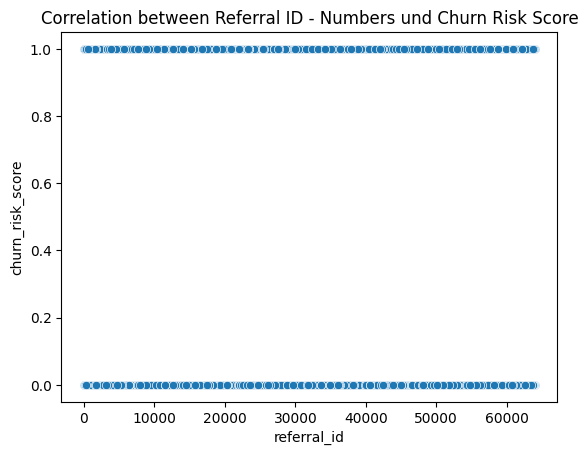

In [13]:
# Examine if the explicit CID-number has an influence on churn risk
df_referral_number = df[['referral_id', 'churn_risk_score']][df['referral_id'].str.startswith('CID')]
# delete 'CID' if its at the begiining to keep only the number
df_referral_number['referral_id'] = df_referral_number['referral_id'].str.replace('CID', '')
df_referral_number['referral_id'] = df_referral_number['referral_id'].astype(int)
print(df_referral_number)
print(df_referral_number['referral_id'].describe())
print(df_referral_number['referral_id'].max())
print(df_referral_number['referral_id'].min())
sns.scatterplot(x='referral_id', y='churn_risk_score', data=df_referral_number)
plt.title('Correlation between Referral ID - Numbers und Churn Risk Score')
plt.show()


There is no correlation between the Number of 'referreal_id' and the target 'churn_risk_score'

-> We will drop 'CID' and keep 'joined_through_referral' to avoid multi-colinearity for some models.

# 4. Time related Data



To be able to correctly process time related data, we convert those variables to datetime.

In [14]:
df.joining_date.max()

Timestamp('2017-12-31 00:00:00')

We want to have a look at the last_visit_time_hours to see if there is a pattern.

In [15]:
# Convert 'last_visit_time' to string
df["last_visit_time"].astype(str)

# Extract hours
df["last_visit_time_hours"] = df["last_visit_time"].apply(lambda x: x.hour)

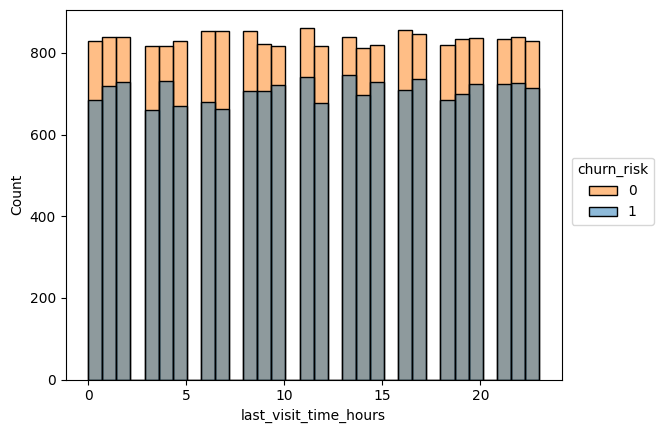

In [16]:
sns.histplot(df, x = df["last_visit_time_hours"] , hue = "churn_risk_score")

plt.legend(title='churn_risk', loc='lower right', labels=['0', '1'], bbox_to_anchor=(1.2, 0.4))
plt.show()


-> We can see that there is no clear pattern in this.

## Todo for cleaning
### features to be ordinal encoded after splitting:
- membership_category 

### features to be further examined:
- 'feedback' group by positive and negative feedback

### to drop
- preferred_offer_types NaN   
- feature: 'past_complaint'   
- feature: 'offer_application_preference' 
- feature: 'CID' 
- feature: 'days_since_last_login' with value -999 


### special cases
- joined_through_referral ? -> Unknown


Limitation: No correlation between numerical and categorical data.